In [3]:
#!pip install --upgrade pip --user
#!pip install numdifftools --user
#!pip install scipy --upgrade --user 

!pip uninstall statsmodels -y --user
!pip install statsmodels==0.10.0rc2 --pre --user


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: --user
     |████████████████████████████████| 8.1MB 8.3MB/s eta 0:00:01     |███████████████▎                | 3.9MB 2.6MB/s eta 0:00:02
  Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


In [20]:
# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel


# generate data
N = 200
x = np.linspace(0,20,N)
e = np.random.normal(loc = 0.0, scale = 7.0, size = N)
y = -9*x + e
df = pd.DataFrame({'dependent_var':y, 'independent_var':x})
df['constant'] = 1



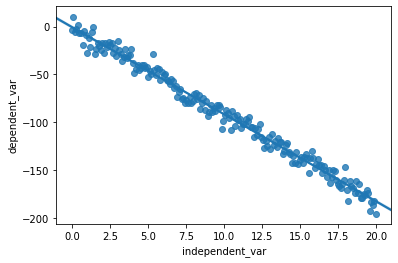

In [21]:
# plot
sns.regplot(df.independent_var, df.dependent_var);



In [4]:
df.head()

,y,x,constant
0,11.600880,0.000000,1
1,-3.151675,0.202020,1
2,2.477100,0.404040,1
3,-4.506962,0.606061,1
4,-1.766583,0.808081,1


Before we go into the implementation of log likelihood, please take a quick look at the documentation
[Scipy norm documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

From the documentation we can see that given the location and scale, we can find the log probabilities of the corresponding normal distribution density

In [17]:
print(f"The density values for data points are {stats.norm.pdf([1,-1], loc=0, scale=1)}")
print(f"The natural log of the density values for the data points are {stats.norm.logpdf([1,-1], loc=0, scale=1)}")



The density values for data points are [0.24197072 0.24197072]
The natural log of the density values for the data points are [-1.41893853 -1.41893853]


[Verify the result yourself](https://www.wolframalpha.com/input/?i=natural+log+of+0.24197072)

## Ordinary Least Squares Fit Using Statsmodels

In [24]:
# split features and target
X = df[['constant', 'independent_var']]
# fit model and summarize
statsmodels_ols_summary = sm.OLS(y,X).fit().summary()
statsmodels_ols_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.281e+04
Date:                Tue, 06 Aug 2019   Prob (F-statistic):          6.42e-182
Time:                        11:30:02   Log-Likelihood:                -660.15
No. Observations:                 200   AIC:                             1324.
Df Residuals:                     198   BIC:                             1331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant           -0.5107      0.930     -0.549      0.583      -2.344       1.323
independent_var    -9.1022      0.080   -113.197      0.000      -9.261      -8.944
==============================================================================
Omnibus:                        0.705   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.703   Jarque-Bera (JB):                0.606
Skew:                          -0.135   Prob(JB):                        0.739
Kurtosis:                       3.003   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Implementing the Likelihood Function

In [1]:
# define likelihood function
def neg_log_likelihood(params):
    """ Computes the """
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    # to find the negative log likelihood, sum the log densities as according to the likelihood function formula
    negative_log_likelihood = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    return(negative_log_likelihood)

# let's start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(neg_log_likelihood, guess, method = 'Nelder-Mead',options={'disp': True})

# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']
print(resultsdf)

NameError: name 'minimize' is not defined

In [19]:
# Let's also see if there are other Scipy options available for optimization
print(minimize.__doc__)

Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized.

            ``fun(x, *args) -> float``

        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of

            - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
            - 'Powell'      :ref:`(see here) <optimize.minimize-powell>`
            - 'CG'          :ref:`(see here) <optimize.minimize-cg>`
            - 'BFGS'        :ref:`(see here) <optimiz

In [10]:
statsmodels_ols_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Tue, 06 Aug 2019   Prob (F-statistic):          1.13e-174
Time:                        11:13:41   Log-Likelihood:                -672.67
No. Observations:                 200   AIC:                             1349.
Df Residuals:                     198   BIC:                             1356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -1.4593      0.990     -1.474      0.142      -3.411       0.493
x             -8.8947      0.086   -103.903      0.000      -9.064      -8.726
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.415
Skew:                          -0.099   Prob(JB):                        0.813
Kurtosis:                       3.101   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
np.round(resultsdf.head(2), 4)

,coef
constant,-0.5108
x,-9.1022
